# regression
predicting a continuous value instead of a discrete label

In [13]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =(boston_housing.load_data())

# feature-wise normalization

In [14]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

# model definition

In [15]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(1)
  ])

  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

  return model

# k-fold validation

In [23]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print(f"Processiong fold #{i}")

  val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]],
      axis=0
  )
  partial_train_targets = np.concatenate(
      [train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]],
      axis=0
  )

  model = build_model()

  history = model.fit(partial_train_data, partial_train_targets,
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs, batch_size=16, verbose=0)

  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)

  mae_history = history.history["val_mae"]
  all_mae_histories.append(mae_history)

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Processiong fold #0
Processiong fold #1
Processiong fold #2
Processiong fold #3


# plot the result

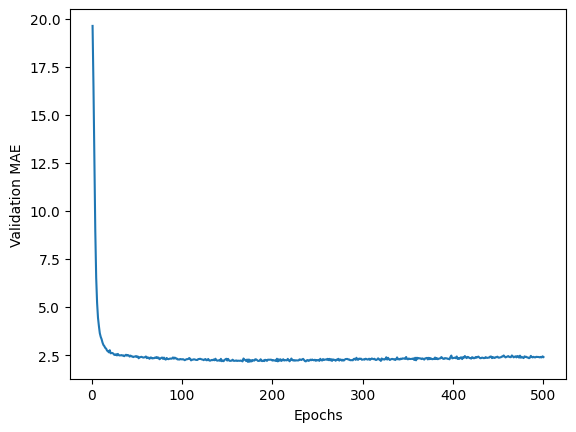

In [24]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

# plot better

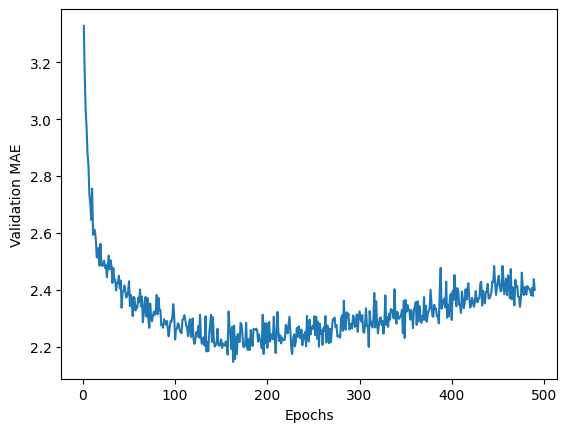

In [25]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

# train the final model with best parameters

In [26]:
model = build_model()

model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.1989 - mae: 2.3179
2.5380241870880127


# generating predictions on new data

In [27]:
predictions = model.predict(test_data)
print(predictions[0])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[9.079855]


# wrapping up
- when there is less data use k-fold validation to reliably evaluate the model
- when little training data is available, use a small model with few intermediate layers in order to avoid overfitting